# Leverage management

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import MeanVariance
from skfin.plot import bar, line

import logging

logging.getLogger("skfin.datasets").setLevel(level=logging.CRITICAL)

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean()
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


Portfolio leverage refers to the use of various financial techniques and instruments to amplify the potential returns of an investment portfolio. Essentially, it involves borrowing funds or using derivative instruments to increase the size of a position beyond the actual capital invested. This approach allows investors to potentially enhance returns, but it also increases risk, as the potential for losses is also magnified.

Leverage can be achieved through several means, including:

1. Margin Trading: Borrowing money from a broker to buy more securities than one could with available cash alone.
1. Derivatives: Using instruments like options, futures, and swaps that provide exposure to an underlying asset at a fraction of the asset’s cost.
1. Borrowing: Taking out loans to invest more capital into the portfolio.
1. Short Selling: Borrowing securities to sell them with the aim of buying them back at a lower price.

While leverage can increase the profitability of winning investments, it can lead to significant losses if the market moves against the leveraged position. Risk management is all the more important when leverage is high. 

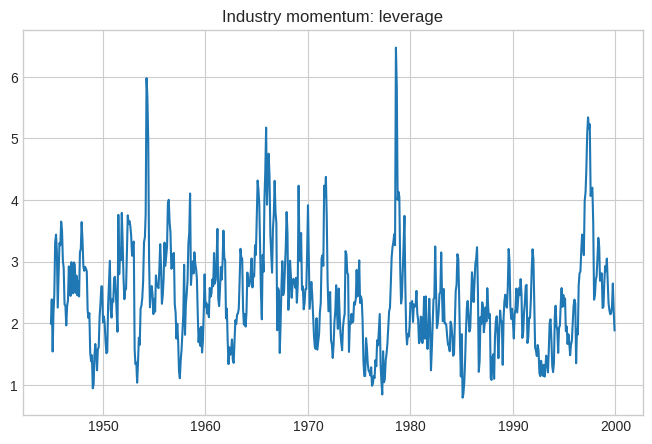

In [2]:
m0 = (
    Backtester(MeanVariance(risk_target=1), name="baseline")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
line(
    m0.h_.abs().sum(axis=1).rename("leverage"),
    title="Industry momentum: leverage",
    legend=False,
)

With the same previous protfolio setup (universe is made of $N$ assets, $r$ is a vector of returns for each asset, $\alpha$ is the asset return forecast: $\alpha = E(r)$ and $V$ is the return covariance matrix that measures that correlation between each asset: $V = Var(r)$), we add a leverage constraint: 


$$U = h^T \alpha - \frac{h^T V h}{2 \lambda} - \eta \sum_n | h_n |,$$

where $\lambda$ is the risk-tolerance and $\eta$ is a measure of the cost of leverage. The leverage metric is an L1-norm $||h ||_1 = \sum_n | h_n |$. 

In [3]:
%%writefile ../skfin/mv_estimators_with_leverage.py
import cvxpy as cp
import numpy as np
from dataclasses import dataclass
from typing import Optional
from skfin.mv_estimators import MeanVariance

def compute_holdings_with_leverage(
    pred, V, A=None, risk_target=None, leverage_target=None
):
    """
    Optimize the array h to maximize np.sum(h * pred) under specified constraints.

    Parameters:
    - pred (numpy.array): A 1D array representing the predicted returns.
    - V (numpy.array): A 2D covariance matrix of returns.
    - leverage_target (float): The desired leverage, defined as the sum of absolute values of h.

    Returns:
    - numpy.array: The optimal array h that maximizes the objective under the constraints.
    """
    n = len(pred)

    # Define the optimization variable
    h = cp.Variable(n)

    # Objective function: maximize the sum of element-wise multiplication of h and pred
    objective = cp.Maximize(cp.sum(h @ pred))

    # Constraints
    constraints = []
    if A is not None:
        constraints += [h.T @ A == 0]
    if risk_target is not None:
        constraints += [
            cp.quad_form(h, V) <= risk_target
        ]  # Ensures the quadratic form (h^T V h) is 1
    if leverage_target is not None:
        constraints += [
            cp.norm(h, 1) <= leverage_target
        ]  # Ensures the sum of absolute values of h equals leverage_target

    # Create and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, eps=1e-9, max_iters=10000, verbose=False)
    problem.solve()

    # Retrieve the optimal value for h
    h_value = h.value

    return h_value


@dataclass
class MeanVarianceWithLeverage(MeanVariance):
    """
    Mean-variance optimization estimator with leverage constraints.

    Attributes:
        leverage_target (Optional[float]): Leverage target for the portfolio.
    """

    leverage_target: Optional[float] = None

    def __post_init__(self):
        """
        Post-initialization to update holdings keyword arguments.
        """
        self.holdings_kwargs = {
            "risk_target": self.risk_target,
            "leverage_target": self.leverage_target,
        }

    @staticmethod
    def compute_batch_holdings(pred, V, A, **kwargs):
        """
        Compute portfolio holdings considering leverage.

        Parameters:
            pred (np.ndarray): Predicted returns (squeezed for computation).
            V (np.ndarray): Covariance matrix.
            A (np.ndarray): Constraint matrix.
            **kwargs: Additional keyword arguments.

        Returns:
            np.ndarray: Portfolio holdings considering leverage.
        """
        pred = pred.squeeze()  # Squeeze prediction array for computation
        h = compute_holdings_with_leverage(pred, V, A, **kwargs)
        return h[:, np.newaxis].T

Overwriting ../skfin/mv_estimators_with_leverage.py


In [4]:
from skfin.mv_estimators_with_leverage import MeanVarianceWithLeverage

In [5]:
for train, test in m0.cv_.split(features):
    m = MeanVariance()
    m.fit(features.values[train], target.values[train])
    h0 = m.predict(features.values[test])

    m_ = MeanVarianceWithLeverage(leverage_target=1)
    m_.fit(features.values[train], target.values[train])
    h = m_.predict(features.values[test], leverage_target=1)
    break

In [6]:
df = pd.DataFrame(
    {"baseline": h0.squeeze(), "leverage=1": h.squeeze()}, index=features.columns
)

In [7]:
print(
    f"Correlation between unconstrained and unit-leverage holdings : {df.corr().iloc[0, 1]:.2f}"
)

Correlation between unconstrained and unit-leverage holdings : 0.79


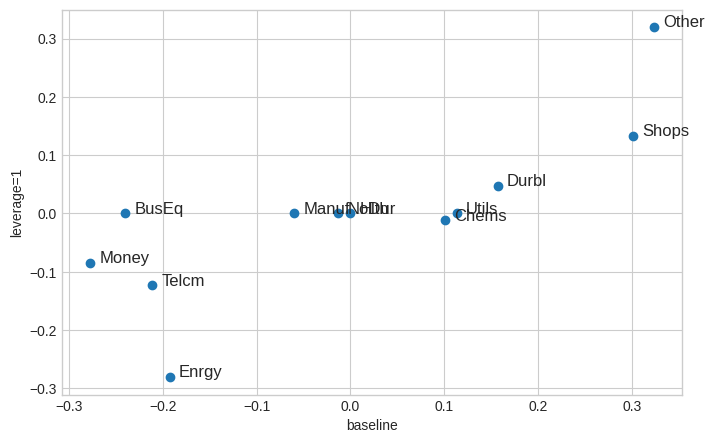

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

cols = list(df.columns)
idx = list(df.index)

ax.scatter(df.iloc[:, 0].values, df.iloc[:, 1].values)
ax.set_xlabel(cols[0])
ax.set_ylabel(cols[1])
xshift, yshift, rotation = 0.01, 0, 0
for i, txt in enumerate(idx):
    ax.text(
        df.iloc[i, 0] + xshift,
        df.iloc[i, 1] + yshift,
        txt,
        fontsize=12,
        rotation=rotation,
    )

In [9]:
%%time 
m = Backtester(estimator=MeanVarianceWithLeverage(leverage_target=1), name="Leverage=1")
pnl_ = m.train(features, target, ret)

CPU times: user 16.6 s, sys: 16 s, total: 32.7 s
Wall time: 10.9 s


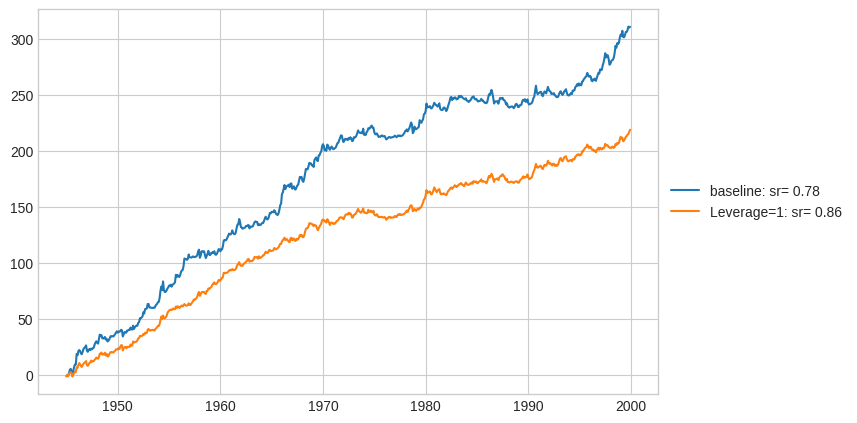

In [10]:
line(pd.concat([m0.pnl_, m.pnl_], axis=1), cumsum=True)

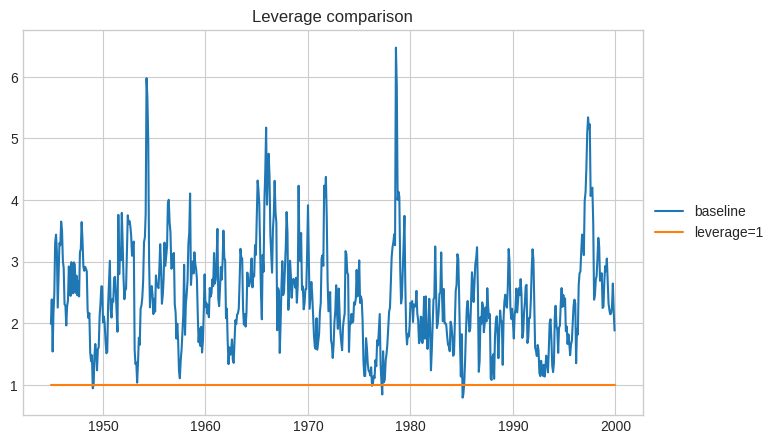

In [11]:
line(
    {"baseline": m0.h_.abs().sum(axis=1), "leverage=1": m.h_.abs().sum(axis=1)},
    title="Leverage comparison",
)

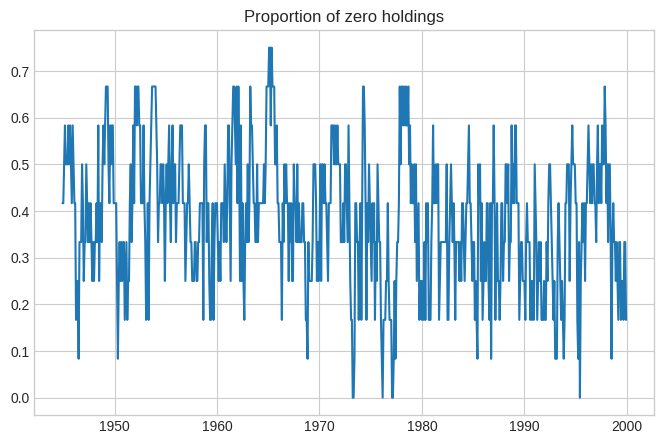

In [12]:
line(
    m.h_.pipe(lambda x: x.abs().le(1e-4)).mean(axis=1),
    legend=False,
    title="Proportion of zero holdings",
)